In [16]:
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
import os
import numpy as np

# Denoising Autoencoders for Graphene EM Images

In [42]:
graphene_noise = np.load('data/graphene/graphene_img_noise.npy')
graphene_clean = np.load('data/graphene/graphene_img_clean.npy')
graphene_seg = np.load('data/graphene/graphene_seg.npy')

In [10]:
N_CHANNELS = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 50
BATCH_SIZE = 64
N_SAMPLES = len(graphene_clean)

graphene_noise.shape, graphene_clean.shape

((10000, 256, 256, 1), (10000, 256, 256, 1))

(-0.5, 255.5, 255.5, -0.5)

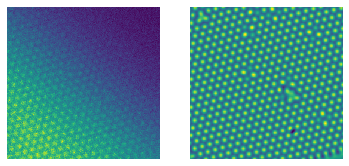

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2)

index = np.random.randint(N_SAMPLES)
img_clean = np.squeeze(graphene_clean[index])
img_noise = np.squeeze(graphene_noise[index])

ax1.matshow(img_noise)
ax1.axis('off')
ax2.matshow(img_clean)
ax2.axis('off')

In [40]:
def normalize_inputs(X, Y):
    X = (X - tf.reduce_min(X)) / (tf.math.reduce_max(X) - tf.math.reduce_min(X))
    Y = (Y - tf.reduce_min(Y)) / (tf.math.reduce_max(Y) - tf.math.reduce_min(Y))
    return X, Y

dataset = tf.data.Dataset.from_tensor_slices((graphene_noise, graphene_clean))
dataset = dataset.shuffle(N_SAMPLES)
dataset = dataset.map(normalize_inputs)
dataset = dataset.batch(BATCH_SIZE)

In [12]:
def autoencoder(img_height, img_width, n_channels=1):
    skip_layers = []
    
    input_layer = tf.keras.layers.Input((img_height, img_width, n_channels))
    x = input_layer
    x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    skip_layers.append(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    skip_layers.append(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    skip_layers.append(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Concatenate()([x, skip_layers.pop(-1)])
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Concatenate()([x, skip_layers.pop(-1)])
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Concatenate()([x, skip_layers.pop(-1)])
    x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    
    x = tf.keras.layers.Conv2D(filters=1, kernel_size=3, activation='linear', padding='same')(x)
    
    model = tf.keras.models.Model(input_layer, x)
    return model

In [ ]:
model = autoencoder(IMG_WIDTH, IMG_HEIGHT, N_CHANNELS)
model.summary()
model.compile(optimizer='adam', loss='mse')
model.fit(dataset, epochs=EPOCHS)

In [18]:
model = tf.keras.models.load_model('weights/graphene-model-weights.h5')

Text(0.5, 1.05, 'Model Output')

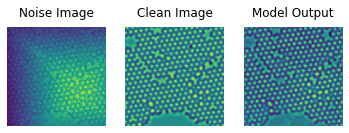

In [39]:
index = np.random.randint(N_SAMPLES)
img_clean = np.squeeze(graphene_clean[index])
img_noise = np.squeeze(graphene_noise[index])

out = model.predict(graphene_noise[index][np.newaxis])
out = np.squeeze(out)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.matshow(img_noise)
ax1.axis('off')
ax1.set_title('Noise Image')
ax2.matshow(img_clean)
ax2.axis('off')
ax2.set_title('Clean Image')
ax3.matshow(out)
ax3.axis('off')
ax3.set_title('Model Output')